# Предсказание стоимости поддержанных автомобилей

## Задача <a class = "tocSkip">

Построить модель для определения рыночной стоимости подержанных автомобилей для сервиса по продаже автомобилей.

Модель будет использована в приложении, которое разрабатывется для привлечения новых клиентов.

Модель должна демонстировать качество прогноза `RMSE` не более 2500, а также быстрое время обучения и предсказания.

## Предоставленные данные <a class = "tocSkip">

Историчекие данные сервиса о технических характеристиках, комплектации и ценах других автомобилей.

Согласно описанию к данным:

- `Brand` — марка автомобиля;
- `DateCrawled` — дата скачивания анкеты из базы;
- `DateCreated` — дата создания анкеты;
- `FuelType` — тип топлива;
- `Gearbox` — тип коробки передач;
- `Kilometer` — пробег (км);
- `LastSeen` — дата последней активности пользователя;
- `Model` — модель автомобиля;
- `NotRepaired` — была машина в ремонте или нет;
- `NumberOfPictures` — количество фотографий автомобиля;
- `PostalCode` — почтовый индекс владельца анкеты (пользователя);
- `Power` — мощность (л. с.);
- `Price` — цена в евро (**целевой признак**);
- `RegistrationMonth` — месяц регистрации автомобиля;
- `RegistrationYear` — год регистрации автомобиля;
- `VehicleType` — тип автомобильного кузова.

## План работы <a class = "tocSkip">

Работа будет включать шесть обязательных этапов и один опциональный:

1. загрузка и изучение данных;
2. подготовка данных; 
3. подготовка выборок к обучению моделей;
4. обучение моделей;
5. анализ моделей;
6. повторное обучение моделей (опциональный этап); и
7. выбор и тестирование лучшей модели.

## Загрузка и изучение данных

Для начала импортируем необходимые библиотеки:

In [1]:
# импорт библиотек numpy, pandas и warnings
import warnings
import numpy as np
import pandas as pd

# импорт библиотек для визуализации графиков
import seaborn as sns
import matplotlib.pyplot as plt

# импорт библиотек для машинного обучения
import catboost as cb
import lightgbm as lgb
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, RandomizedSearchCV, train_test_split

Также установим стили отображения датасетов, предупреждений и графиков:

In [2]:
# установление стиля отображения датасетов
pd.set_option('display.max_colwidth', None)

# установление стиля отображения предупреждений
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# установление стиля отображения графиков
sns.set_style("whitegrid")

Прочитаем файл с данными:

In [3]:
# чтение файла с данными
df = pd.read_csv('/datasets/autos.csv')

Изучим 5 случайных объектов датасета:

In [4]:
# вывод на экран пяти случайных объектов датасета
display(df.sample(5, random_state=12345))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
18734,2016-04-04 13:36:58,16900,bus,2010,auto,150,viano,150000,4,gasoline,mercedes_benz,no,2016-04-04 00:00:00,0,60326,2016-04-05 12:18:31
141787,2016-03-07 17:57:08,15500,other,2011,manual,143,1er,40000,5,gasoline,bmw,no,2016-03-07 00:00:00,0,35083,2016-04-06 20:19:15
37523,2016-03-24 09:37:02,3600,sedan,2004,manual,125,astra,150000,12,petrol,opel,no,2016-03-24 00:00:00,0,13627,2016-03-24 10:38:57
194192,2016-03-15 09:49:03,8990,sedan,2007,auto,224,c_klasse,150000,9,gasoline,mercedes_benz,no,2016-03-15 00:00:00,0,58135,2016-03-18 02:17:06
110210,2016-03-29 23:43:52,2500,other,1994,manual,68,transporter,150000,9,gasoline,volkswagen,no,2016-03-29 00:00:00,0,24598,2016-04-02 12:45:46


Мы видим, что:
- один объект содержит информацию об одной анкете о продаже автомобиля;
- по каждому объекто доступно 16 признаков:
    - 5 количественных (*Price*, *RegistrationYear*, *Power*, *Kilometer*, *NumberOfPictures*);
    - 8 категориальных (*VehicleType*, *Gearbox*, *Model*, *RegistrationMonth*, *FuelType*, *Brand*, *NotRepaired*, *PostalCode*);
    - 3 календарных (*DateCrawled*, *DateCreated*, *LastSeen*);
- во всех 5 случайных объектах значение признака *NumberOfPictures* равно нулю.

Также изучим общую информацию о датасете:

In [5]:
# вывод на экран общей информации о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Мы видим, что:
- в датасете 354 369 объектов;
- календарные признаки *DateCrawled*, *DateCreated* и *LastSeen* имеют тип *object*, для работы с данными признаками необходимо изменить их тип на *datetime*;
- признаки, которые содержат числовые значения имеют тип *int64*; в зависимости от диапазона их значений в целях оптимизации данных возможно изменить их тип на *int64*, *int16* или *int8*; 
- в значениях отдельных признаков есть пропуски.

### Изучение пропусков

Изучим пропуски:

In [6]:
# вывод на экран процента пропусков (по убыванию)
df.isna().sum().sort_values(ascending=False)/len(df)*100

NotRepaired          20.079070
VehicleType          10.579368
FuelType              9.282697
Gearbox               5.596709
Model                 5.560588
DateCrawled           0.000000
Price                 0.000000
RegistrationYear      0.000000
Power                 0.000000
Kilometer             0.000000
RegistrationMonth     0.000000
Brand                 0.000000
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

Мы видим, что:
- пропуски есть в значениях 5 признаков;
- пропуски есть только в категориальных признаках;
- процент пропусков составляет ~6-20 процентов.

### Изучение количественных признаков

Датасет содержит 5 количественных признаков: *Price*, *RegistrationYear*, *Power*, *Kilometer*, *NumberOfPictures*.

Изучим описательную статистику по ним:

In [7]:
# вывод на экран описательной статистики по количественным признакам
display(df[['Price', 'RegistrationYear', 'Power', 'Kilometer', 'NumberOfPictures']].describe())

,Price,RegistrationYear,Power,Kilometer,NumberOfPictures
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.0
mean,4416.656776,2004.234448,110.094337,128211.172535,0.0
std,4514.158514,90.227958,189.850405,37905.341530,0.0
min,0.000000,1000.000000,0.000000,5000.000000,0.0
25%,1050.000000,1999.000000,69.000000,125000.000000,0.0
50%,2700.000000,2003.000000,105.000000,150000.000000,0.0
75%,6400.000000,2008.000000,143.000000,150000.000000,0.0
max,20000.000000,9999.000000,20000.000000,150000.000000,0.0


Мы видим, что:
- *Price* содержит аномальное минимальное значение *0*;
- *RegistrationYear* содержит аномальные минимальное (*1000*) и максимальное (*9999*) значения;
- *Power* содержит содержит аномальные минимальное (*0*) и максимальное (*20000*) значения;
- *NumberOfPictures* содержит только нулевые значения (т.е. данный признак неинформативен для целей построения модели).

Дополнительно посчитаем процент нулевых значений признаков *Price* и *Power*:

In [8]:
# вывод на экран процента нулевых значений Price и Power
print(df[['Price', 'Power']][df == 0].count().sort_values(ascending=False)/len(df.index)*100)

Power    11.351162
Price     3.039769
dtype: float64


Процент нулевых значений находится в диапазоне значений пропусков в категориальных признаках, т.е. нулевые значения могут являться неявными пропусками.

Для целей определения границ аномальных значений признаков *Price*, *RegistrationYear* и *Power* изучим их распределение.

Для удобства анализа количественных признаков напишем фунцию *get_num_feature_information*:

In [9]:
def get_num_feature_information(feature, color, bins=20, xticks_range=None):
    
    '''
    Функция в отношении количественного признака (столбца датасета) выводит на экран:
    - описательную статисктику методом describe();
    - гистограмму; и
    - диаграмму размаха
    
    Входные параметры:
    - feature - признак (столбец датасета);
    - color - цвет гистограммы и диаграммы размаха;
    - bins - количество корзин для построения гистограммы (по умолчанию 20);
    - xticks_range - устанавливает диапазон значений деления оси X графиков (по умолчанию не установлен)
    
    '''
    
    print(feature.name)
    print()
    print(feature.describe())
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, 
                                   ncols=1, 
                                   figsize=(12, 12),
                                   gridspec_kw={'height_ratios': [3, 1]}
                                  )
    
    sns.histplot(x=feature,
                 color=color,
                 kde=True,
                 alpha = 0.5,
                 ax=ax1,
                 bins=bins
                )
    
    sns.boxplot(x=feature,
                color=color,
                linewidth=1,
                ax=ax2
               )
    
    if xticks_range != None:
        for ax in (ax1, ax2):
            ax.set_xticks(xticks_range)
    
    fig.suptitle('Распределение признака ' + feature.name)
    
    plt.tight_layout()
    plt.show()

#### Price

Изучим распределение значений признака *Price*, исключив нулевые значения:

Price

count    343597.000000
mean       4555.121974
std        4515.058553
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64


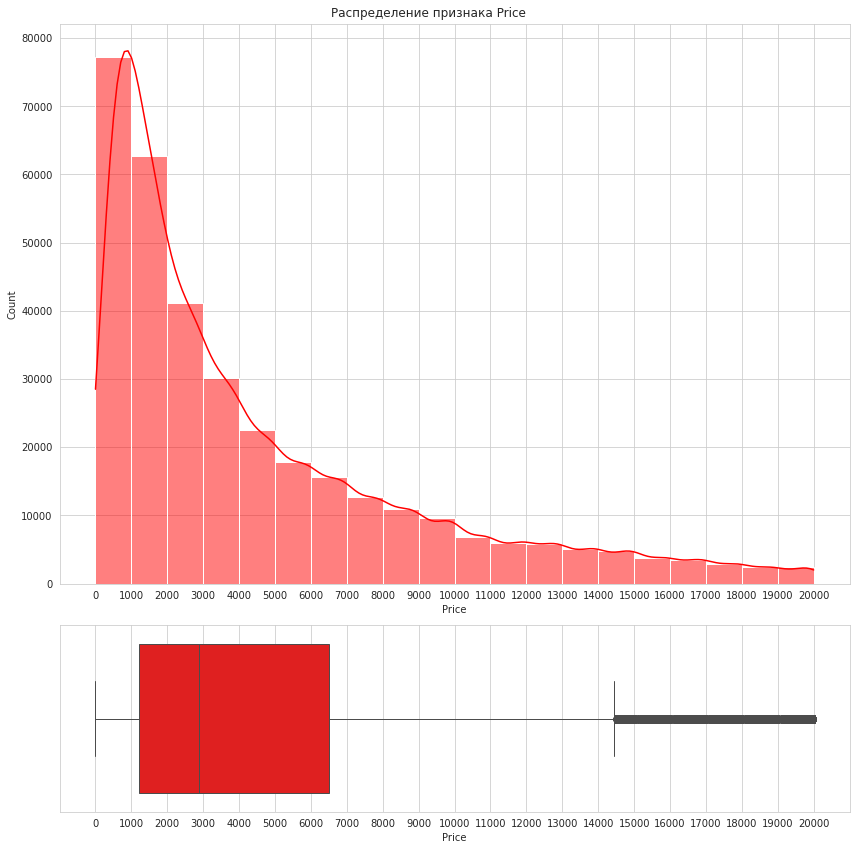

In [10]:
# создание выборки с объектами, цена которых не равна нулю
price_nonzero = df.query('Price != 0')['Price']

# применение функции get_num_feature_information
get_num_feature_information(price_nonzero, 'red', xticks_range= range(0,21000,1000))

Мы видим, что:
- среднее значение цены - 2890 евро;
- половина значений признака находится в диапазоне от 1200 до 6 500 евро;
- даже после исключения нулевых значений миниальное значение признака (*1 евро*) выглядит аномальным;
- на диаграмме размаха присутствуют выбросы после ~14 500 евро (однако такие значения не выглядят аномальными).

По итогам изучения данных из открытых источников (анкет крупного европейского сервиса по продаже поддержанных автомобилей *AutoScout24.de*) мы пришли к выводу, что минимальная реальная стоимость поддержанного автомобиля составляет 100 евро.

Посчитаем процент объектов с ценой меньше 100 евро (включая нулевые значения):

In [11]:
# расчет и вывод на экран процента объектов с ценой меньше 100 евро
price_below_100 = len(df.query('Price < 100')) / len(df)

print('Процент объектов с ценой ниже 100 евро:', '{:.2%}'.format(price_below_100))

Процент объектов с ценой ниже 100 евро: 3.76%


Таким образом, процент объектов с аномальными значениями цены не превышает 4%. 

#### Registration year

Для целей построения моделей предположим, что:
- минимальное нормальное значение признака - 1900 (согласно открытым источникам, регистрация автомобилей в разных европейских странах началась в конце 19 века);
- максимальное нормальное значение признака - 2016 (год скачивания анкет).

Исходя из данных предположений изучим распределение признака:

RegistrationYear

count    339773.000000
mean       2002.482222
std           7.091181
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64


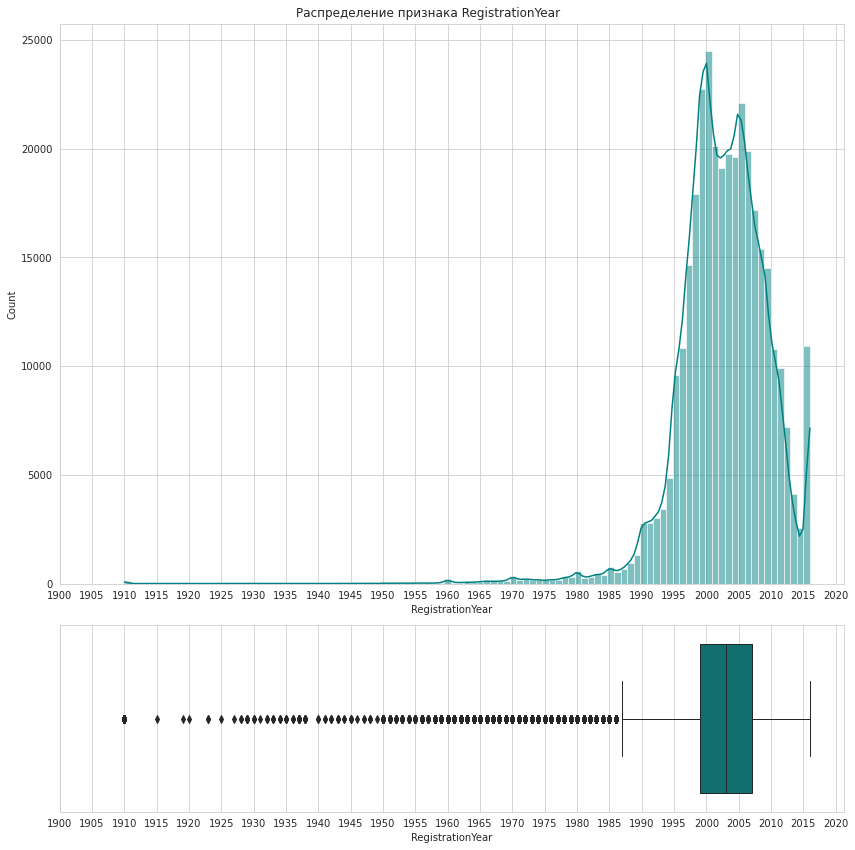

In [12]:
# создание выборки с объектами, год регистрации которых находится в диапазоне от 1900 до 2016
regyear_1900_2016 = df.query('1900 <= RegistrationYear <= 2016')['RegistrationYear']

# применение функции get_num_feature_information
get_num_feature_information(regyear_1900_2016, 'teal', bins=105, xticks_range= range(1900,2021,5))

Мы видим, что:
- средний год регистрации - 2003;
- половина значений признака находится в диапазоне от 1999 до 2007 года;
- отдельный пик регистрации автомобилей наблюдается в 2016 году;
- на диаграмме размаха присутствуют выбросы до 1985 года (однако такие значения не выглядят аномальными).

Посчитаем процент объектов, которые мы классифицировали как аномальные на основании года регистрации:

In [13]:
# расчет и вывод на экран процента объектов с годом регистрации до 1900 или после 2016
regyear_before_1900 = len(df.query('RegistrationYear < 1900')) / len(df)
regyear_after_2016 = len(df.query('RegistrationYear > 2016')) / len(df)
regyear_before_1900_after_2016 = regyear_before_1900 + regyear_after_2016

print('Процент объектов с аномально низким значением года регистрации:', '{:.2%}'.format(regyear_before_1900))
print('Процент объектов с аномально высоким значением года регистрации:', '{:.2%}'.format(regyear_after_2016))
print('Процент объектов с аномальным значением года регистрации:', 
      '{:.2%}'.format(regyear_before_1900_after_2016))

Процент объектов с аномально низким значением года регистрации: 0.02%
Процент объектов с аномально высоким значением года регистрации: 4.10%
Процент объектов с аномальным значением года регистрации: 4.12%


Мы видим, что:
- процент объектов с аномальным значением года регистрации составляет ~4%;
- большая часть таких объектов приходится на период после 2016 года.

Изучим значения признака объектов с годом регистрации после 2016:

In [14]:
# вывод на экран 5 наиболее частных значений признака RegistrationYear после 2016
df.query('RegistrationYear > 2016')['RegistrationYear'].value_counts().head(5)

2017    10441
2018     3959
9999       26
2019       25
5000       17
Name: RegistrationYear, dtype: int64

Мы видим, что основная часть аномальных значений пригодится на 2017 и 2018 годы. Мы не можем на основе данных установить природу данных аномальных значений (например, значение 2017 может являться как ошибочно указанным значением 2016, так и ошибочно указанным значением 2007).

#### Power

Поскольку у нас нет предметных знаний о мощности автомобилей, которые позволили бы нам установить верхнюю и нижнюю границы нормальных значений, предположим, что аномальными будут один процент самых низких и самых высоких значений признака (без учета нулевых значений).

Исхода из данного предположения:
- найдем минимальное и максимальное нормальные значения признака; и
- изучим его распределение.

Минимальное нормальное значение признака Power (л.с.): 40.0
Максимальное нормальное значение признака Power (л.с.): 340.0

Power

count    311180.00000
mean        119.54956
std          50.91660
min          40.00000
25%          75.00000
50%         110.00000
75%         150.00000
max         340.00000
Name: Power, dtype: float64


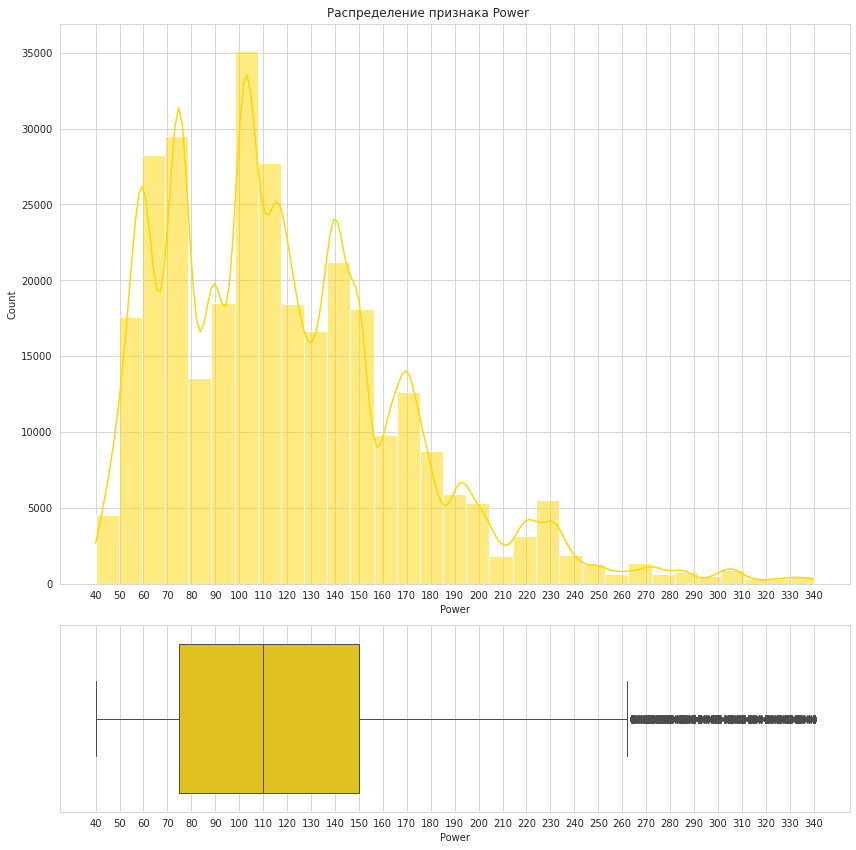

In [15]:
# создание выборки с объектами, мощность которых не равна нулю
power_nonzero = df.query('Power != 0')['Power']

# опредедение минимального и максимального нормальных значений признака
# создание выборки с объектами, мощность которых лежит в нормальном диапазоне
power_min = np.quantile(power_nonzero, 0.005)
power_max = np.quantile(power_nonzero, 0.995)
power_min_max = df.query('@power_min <= Power <= @power_max')['Power']

# вывод на экран минимального и максимального нормальных значений признака
print('Минимальное нормальное значение признака Power (л.с.):', power_min)
print('Максимальное нормальное значение признака Power (л.с.):', power_max)
print()

# применение функции get_num_feature_information
get_num_feature_information(power_min_max, 'gold', 31, range(int(power_min), int(power_max+1), 10))

Мы видим, что:
- средняя мощность составляет 110 л.с.;
- половина значений находится в диапазоне от 75 до 150 л.с.;
- пики значений приходятся на автомобили мощностью ~60-70, 100-110 и 140 л.с.;
- на диаграмме размаха присутствуют выбросы после 260 л.с. (однако такие значения не выглядят аномальными).

Посчитаем процент объектов, которые мы классифицировали как аномальные:

In [16]:
# расчет и вывод на экран процента объектов с мощностью менее 40 или более 340 л.с.
power_below_40 = len(df.query('Power < @power_min')) / len(df)
power_above_340 = len(df.query('Power > @power_max')) / len(df)
power_below_40_or_above_340 = power_below_40 + power_above_340

print('Процент объектов с аномально низким значением мощности:', '{:.2%}'.format(power_below_40))
print('Процент объектов с аномально высоким значением мощности:', '{:.2%}'.format(power_above_340))
print('Процент объектов с аномальным значением года регистрации:', 
      '{:.2%}'.format(power_below_40_or_above_340))

Процент объектов с аномально низким значением мощности: 11.75%
Процент объектов с аномально высоким значением мощности: 0.43%
Процент объектов с аномальным значением года регистрации: 12.19%


Мы видим, что процент объектов с аномальным значением мощности составляет ~12% (как мы установили ранее, большая часть таких объектов имеет нулевое значение мощности).

### Изучение категориальных признаков

Датасет содержит 8 категориальных признаков: *VehicleType*, *Gearbox*, *Model*, *RegistrationMonth*, *FuelType*, *Brand*, *NotRepaired*, *PostalCode*.

Изучим по каждому признаку количество уникальных значений и сами уникальные значения:

In [17]:
# создание списка названий категориальных признаков
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'RegistrationMonth', 
                        'FuelType', 'Brand', 'NotRepaired', 'PostalCode']

# вывод на экран количества уникальных значений категориальных признаков (по убыванию)
print('Количество уникальных значений:')
print()
print(df[categorical_features].nunique().sort_values(ascending=False))
print()

# по каждому категориальному признаку вывод на экран уникальных значений
print('Уникальные значения:')
print()
for col in df[categorical_features].columns:    
    print(col)
    print()
    print(df[col].sort_values().unique())
    print('-' * 80)
    print()

Количество уникальных значений:

PostalCode           8143
Model                 250
Brand                  40
RegistrationMonth      13
VehicleType             8
FuelType                7
Gearbox                 2
NotRepaired             2
dtype: int64

Уникальные значения:

VehicleType

['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan]
--------------------------------------------------------------------------------

Gearbox

['auto' 'manual' nan]
--------------------------------------------------------------------------------

Model

['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_

Мы видим, что:
- признаки *Model* и *PostalCode* содержат 250 и 8 143 уникальных значений (т.е. каждый содержит больше значений, чем все остальные категориальные признаки вместе взятые), поэтому использование данных признаков для построения моделей на основе алгоритмов, требующих кодирования категориальных признаков, может существенно увеличить время обучения таких моделей;
- категориальные признаки не содержат аномальных значений (среди уникальных значений *PostalCode* есть как четырех-, так и пятизначные значения, однако поскольку мы не знаем, в какой стране (или странах) работает сервис, то мы не можем однозначно определить, что какие-либо значения данного признака являются аномальными);
- признаки содержат неявные дубликаты:
    - *FuelType*: значения *gasoline* и *petrol* являются разными названиями одного и того же типа топлива, используемыми в разных странах;
    - *Brand*: значения *rover* и *land_rover* являются разным написанием одной и той же марки;
    - *Model*: *rangerover* и *range_rover* являются разным написанием одной и той же модели.

### Изучение календарных признаков

Датасет содержит 3 календарных признака: *DateCrawled*, *DateCreated* и *LastSeen*.

Для работы с ними сначала изменим тип данных признаков на *datetime*:

In [18]:
# создание списка названий календарных признаков
datetime_features = ['DateCrawled', 'DateCreated', 'LastSeen']

# изменение типа данных столбцов с календарными признаками
df[datetime_features] = df[datetime_features].apply(pd.to_datetime)

# проверка изменения типа данных
df[datetime_features].dtypes

DateCrawled    datetime64[ns]
DateCreated    datetime64[ns]
LastSeen       datetime64[ns]
dtype: object

Изучим описательную статистику по календарным признакам:

In [19]:
# применение метода describe()
df[datetime_features].describe()

,DateCrawled,DateCreated,LastSeen
count,354369,354369,354369
unique,271174,109,179150
top,2016-03-24 14:49:47,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,13719,17
first,2016-03-05 14:06:22,2014-03-10 00:00:00,2016-03-05 14:15:08
last,2016-04-07 14:36:58,2016-04-07 00:00:00,2016-04-07 14:58:51


Мы видим, что:
- в датасете представлены данные об анкетах, размещенных с марта 2014 по апрель 2016 года;
- анкеты были скачаны с сайта с марта по апрель 2016 года.

Проверим датасет на наличие следующих аномалий:
- дата скачивания анкеты раньше даты создания анкеты;
- дата последней активности пользователя раньше даты создания анкеты.

In [20]:
# вывод на экран количества объектов, в которых:
# - дата скачивания анкеты раньше даты создания анкеты;
# - дата последней активности пользователя раньше даты создания анкеты.
print('Количество объектов, в которых дата скачивания анкеты раньше даты создания анкеты:',
      df[datetime_features].query('DateCrawled < DateCreated')['DateCrawled'].count())
print('Количество объектов, в которых дата последней активности пользователя раньше даты создания анкеты:',
      df[datetime_features].query('LastSeen < DateCreated')['DateCrawled'].count())

Количество объектов, в которых дата скачивания анкеты раньше даты создания анкеты: 0
Количество объектов, в которых дата последней активности пользователя раньше даты создания анкеты: 0


Аномалии не выявлены.

### Выводы

По результатам изучения данных мы пришли к следующим выводам:

*Общие выводы*

- в датасете 354 369 объектов, один объект содержит информацию об одной анкете о продаже автомобиля;
- по каждому объекто доступно 16 признаков:
    - 5 количественных (*Price*, *RegistrationYear*, *Power*, *Kilometer*, *NumberOfPictures*);
    - 8 категориальных (*VehicleType*, *Gearbox*, *Model*, *RegistrationMonth*, *FuelType*, *Brand*, *NotRepaired*, *PostalCode*);
    - 3 календарных (*DateCrawled*, *DateCreated*, *LastSeen*).
- в значениях 5 категориальных признаков есть пропуски, их процент составлет ~6-20 процентов.

*Количественные признаки*

- все количественные признаки имеют тип *int64*; в зависимости от диапазона их значений в целях оптимизации данных возможно изменить их тип на *int64*, *int16* или *int8*;
- признак *NumberOfPictures* содержит только нулевые значения (т.е. данный признак неинформативен для целей построения модели);
- признаки *Price* *RegistrationYear* и *Power* содержат аномальные минимальное и максимальное значения (по итогам их анализа мы подобрали пороги нормальных значений);
- признаки *Price* и *Power* содержат нулевые значения (~3-11 процентов), которые могут быть неявными пропусками.

*Категориальныпе признаки*

- признаки *Model* и *PostalCode* содержат 250 и 8 143 уникальных значений, поэтому использование данных признаков для построения моделей на основе алгоритмов, требующих кодирования категориальных признаков, может существенно увеличить время обучения таких моделей;
- категориальные признаки не содержат аномальных значени;
- признаки *FuelType*, *Brand* и *Model* содержат неявные дубликаты.

*Календарные признаки*

- календарные признаки имеют тип *object*, для работы с данными признаками необходимо изменить их тип на *datetime*;
- в датасете представлены данные об анкетах, размещенных с марта 2014 по апрель 2016 года;
- анкеты были скачаны с сайта с марта по апрель 2016 года;
- аномалии не выявлены.

На следующем этапе подготовим данные, устранив выявленные пропуски, аномальные значения и дубликаты.

## Подготовка данных

В ходе подготовки данных мы:
- устраним пропуски; 
- устраним аномальные значения;
- устраним неявные дубликаты;
- проведем поиск и устранение явных дубликатов; и
- оптимизируем тип данных признаков с числовыми значениями.

После вышеуказанных действий мы рассчитаем, на сколько процентов сократился исходный датасет.

Перед подготовкой данной сохраним размер исходного датасета в отдельную переменную

In [21]:
# создание переменной с размером исходного датасета
df_initital_shape = df.shape

# проверка создания переменной с размером исходного датасета
df_initital_shape

(354369, 16)

### Устранение пропусков

Как мы установили ранее: 
- пропуски содержатся в 5 категориальных признаках;
- пропуски составляют ~6-20 процентов данных.

Мы не можем восстановить пропущенные значения на основании значений других признаков, а удаление содержащих пропуски объектов приведет к потере значительной доли данных. Поэтому заполним пропуски значением - индикатором пропуска *unknown*:

In [22]:
# заполнение пропусков
df.fillna('unknown', inplace=True)

# проверка устранения пропусков
print()
print('Количество пропусков:', df.isna().sum().sum())


Количество пропусков: 0


### Устранение аномальных значений

Как мы установили ранее: 
- аномальные значения содержатся в 3 количественных признаках;
- аномальные значения составляют ~4-12 процентов данных.

Мы не можем восстановить пропущенные значения на основании значений других признаков, а их заполнение константным значением может привести к искажению данных. Поэтому устраним аномальные значения путем удаления содержащих аномальные значения объектов:

In [23]:
# устранение аномальных значений
df = df.query(
    '100 <= Price and \
    1900 <= RegistrationYear <= 2016 and \
    40 <= Power <= 340')

# проверка устранения аномальных значений
anomalies_count = len(df.query(
    'Price < 100 or \
    RegistrationYear < 1900 or \
    RegistrationYear > 2016 or \
    Power < 40 or \
    Power > 340'))

print('Количество объектов с аномальными значениями:', anomalies_count)

Количество объектов с аномальными значениями: 0


### Устранение неявных дубликатов

Устраним выявленные неявные дубликаты:

In [24]:
# создание словаря с неявными дубликатами их заменами
duplicates_dict = {
    'gasoline':'petrol',
    'rover':'land_rover',
    'rangerover':'range_rover'
}

# замена неявных дубликатов
df.replace(duplicates_dict, inplace=True)

# проверка замены неявных дубликатов
duplicates_count = len(df.query('FuelType == "gasoline" or \
                                Brand == "rover" or \
                                Model == "rangerover"'))

print('Количество неявных дубликатов:', duplicates_count)

Количество неявных дубликатов: 0


### Поиск и устранение явных дубликатов

Произведем поиск явных дубликатов:

In [25]:
# подсчет и вывод на экран количества явных дубликатов
print('Количество явных дубликатов:', df.duplicated().sum())

Количество явных дубликатов: 4


Датасет содержит 4 явных дубликата. Изучим их:

In [26]:
# вывод на экран дубликатов
df[df.duplicated(keep=False)].sort_values(by='DateCrawled')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,petrol,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,petrol,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54


С одной стороны, датасет не содержит уникальных идентификаторов анкет, которые позволили сделать однозначный вывод о том, что объекты с одинаковыми признаками являются дубликатами.

С другой стороны, поскольку у объектов совпадают 16 признаков (включая дату и время создания анкеты и последней активности пользователя), с высокой вероятностью данные объекты являются дубликатами.

С учетом незначительного процента дубликатов устраним их путем удаления объектов-дубликатов:

In [27]:
# удаление явных дубликатов
df.drop_duplicates(inplace=True, ignore_index=True)

# проверка удаления явных дубликатов
print('Количество явных дубликатов:', df.duplicated().sum())

Количество явных дубликатов: 0


### Оптимизация типа данных признаков с числовыми значениями

Для оптимизации изучим диапазон значений каждого признака:

In [28]:
# вывод на экран описательной статистики по датасету
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,293006.000000,293006.000000,293006.000000,293006.000000,293006.000000,293006.0,293006.000000
mean,4848.745814,2002.900842,120.055204,128468.683235,6.001577,0.0,51256.145256
std,4585.274930,6.379632,50.952704,36540.942951,3.579975,0.0,25758.830558
min,100.000000,1910.000000,40.000000,5000.000000,0.000000,0.0,1067.000000
25%,1350.000000,1999.000000,77.000000,125000.000000,3.000000,0.0,30952.000000
50%,3200.000000,2003.000000,111.000000,150000.000000,6.000000,0.0,50321.000000
75%,6990.000000,2007.000000,150.000000,150000.000000,9.000000,0.0,72108.000000
max,20000.000000,2016.000000,340.000000,150000.000000,12.000000,0.0,99998.000000


Исходя из диапазона значений изменим тип данных признаков:

In [29]:
# вывод на экран общей информации о датасете до изменения типа данных
df.info()
print()

# изменение типа данных
df[['Kilometer', 'PostalCode']] = df[['Kilometer', 'PostalCode']].astype('int32')
df[['Price', 'RegistrationYear', 'Power']] = df[['Price', 'RegistrationYear','Power']].astype('int16')
df['RegistrationMonth'] = df['RegistrationMonth'].astype('int8')

# проверка изменения типа данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293006 entries, 0 to 293005
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        293006 non-null  datetime64[ns]
 1   Price              293006 non-null  int64         
 2   VehicleType        293006 non-null  object        
 3   RegistrationYear   293006 non-null  int64         
 4   Gearbox            293006 non-null  object        
 5   Power              293006 non-null  int64         
 6   Model              293006 non-null  object        
 7   Kilometer          293006 non-null  int64         
 8   RegistrationMonth  293006 non-null  int64         
 9   FuelType           293006 non-null  object        
 10  Brand              293006 non-null  object        
 11  NotRepaired        293006 non-null  object        
 12  DateCreated        293006 non-null  datetime64[ns]
 13  NumberOfPictures   293006 non-null  int64   

В результате оптимизации типа данных размер датасета сократился с 35,8 до 26,5 Мб.

Рассчитаем, на сколько процентов сократился исходный датасет в результате подготовки данных:

In [30]:
# расчет и вывод на экран процента, на который сократился исходный датасет в результате подготовки данных
df_preprocessed_percent = len(df) / df_initital_shape[0]

print('В результате подготовки данных исходный датасет сократился на', '{:.2%}'.format(1 - df_preprocessed_percent))

В результате подготовки данных исходный датасет сократился на 17.32%


### Выводы

В ходе подготовки данных мы:

- устранили пропуски в признаках *NotRepaired*, *VehicleType*, *FuelType*, *Gearbox* и *Model* путем их заполнения значением-индикатором пропуска *unknown*; 
- устранили аномальные значения в признаках *Price*, *RegistrationYear* и *Power* путем удаления содержащих их объектов;
- устранили неявные дубликаты в признаках *FuelType*, *Brand* и Model*;
- удадлили объекты, которые мы классифицировали как явные дубликаты; и
- оптимизировали тип данных признаков с числовыми значениями, уменьшив размер датасетас 35,8 до 26,5 Мб.

В результате подготовки данных количество объектов в датасете сократилось на ~17%.

На следующем этапе подготовим выборки к обучению моделей.

## Подготовка выборок к обучению моделей

На данном этапе подготовим выборки:

- удалим неинформативные признаки;
- сохраним признаки и целевой признак в отдельные переменные;
- разделим данные на обучающую и тестовую выборки.

Поскольку на следующем этапе мы планируем обучить 4 модели на основе разных аглоритмов (*ElasticNet*, *RandomForestRegressor*, *CatBoostRegressor* и *LGBMRegressor*), для каждой из моделей необходимо провести дополнительную подготовку выборок:

- *ElasticNet* как линейная модель требует масштабирования количественных признаков;
- *ElasticNet* и *RandomForestRegressor* требуют кодирования категориальных признаков; 
- *LGBMRegressor* требует изменения типа категориальных признаков на *category*.

С учетом вышеуказанного, мы подготовим 3 сета выборок (у *ElasticNet* и *RandomForestRegressor* будет единый сет).

### Удаление неинформативных признаков

Удалим из следующие неинформативные признаки:
- *NumberOfPictures* (все значения признака равны нулю);
- *DateCrawled* (характеризует период создания датасета); 
- *DateCreated*, *LastSeen* (характеризуют поведение пользователя).

In [31]:
# удаление неинформативных признаков
df.drop(columns=['NumberOfPictures', 'DateCrawled', 'DateCreated', 'LastSeen'], inplace=True)

# проверка удаления неинформативных признаков
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired',
       'PostalCode'],
      dtype='object')

### Создание переменных с признаками и целевым признаком

In [32]:
# создание переменных с признаками и целевым признаком
features = df.drop(columns=['Price'])
target = df['Price']

# проверка создания переменных с признаками и целевым признаком
print(features.shape)
print(features.columns)
print()
print(target.shape)
print(target.name)

(293006, 11)
Index(['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired',
       'PostalCode'],
      dtype='object')

(293006,)
Price


### Разделение данных на обучающую и тестовую выборки

При разделении данных будем использовать соотношениие обучающей и тестовой выборки 3:1:

In [33]:
# разделение данных на обучуающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

# проверка разделения данных на обучуающую и тестовую выборки
for subset in features_train, features_test, target_train, target_test:
    print(subset.shape)

(219754, 11)
(73252, 11)
(219754,)
(73252,)


### Подготовка сета выборок для *ElasticNet* и *RandomForestRegressor*

Для начала сохраним копии признаков для обучающей и тестовой выборок в отдельные переменные

In [34]:
# создание копий features_train и features_test
features_train_en_rf = features_train.copy()
features_test_en_rf = features_test.copy()

#### Масштабирование количественных признаков

Для масштабирования будем использовать метод стандартизации данных:

In [35]:
# создание списка с названиями количественных признаков
features_numeric = ['RegistrationYear', 'Power', 'Kilometer']

# создание объекта структуры StandardScaler
scaler = StandardScaler()

# обучение StandardScaler на признаках обучающей выборки и
# преобразование признаков обучающей и тестовой выборок
features_train_en_rf[features_numeric] = scaler.fit_transform(
    features_train_en_rf[features_numeric])
features_test_en_rf[features_numeric] = scaler.transform(
    features_test_en_rf[features_numeric])

# проверка преобразования признаков
for subset in features_train_en_rf, features_test_en_rf:
    display(subset[features_numeric].describe())

,RegistrationYear,Power,Kilometer
count,2.197540e+05,2.197540e+05,2.197540e+05
mean,7.747895e-15,1.093521e-16,1.843012e-16
std,1.000002e+00,1.000002e+00,1.000002e+00
min,-1.455985e+01,-1.571271e+00,-3.387951e+00
25%,-6.112722e-01,-8.457513e-01,-9.699107e-02
50%,1.563020e-02,-1.594489e-01,5.886255e-01
75%,6.425326e-01,5.856794e-01,5.886255e-01
max,2.053063e+00,4.311321e+00,5.886255e-01


,RegistrationYear,Power,Kilometer
count,73252.000000,73252.000000,73252.000000
mean,0.000358,-0.005989,-0.007454
std,0.999406,0.996435,1.008445
min,-11.738790,-1.571271,-3.387951
25%,-0.611272,-0.865360,-0.096991
50%,0.015630,-0.198666,0.588626
75%,0.642533,0.585679,0.588626
max,2.053063,4.311321,0.588626


#### Кодирование категориальных признаков

Исходя из значений категориальных признаков для их кодирования наиболее подходит  метод *One-Hot Encoding*. До начала кодирования исключим из выборок признаки *Model* и *PostalCode*: с учетом большого количества уникальных значений данных признаков их кодирование выбранным методом приведет к созданию большого количества признаков, что может существенно увеличить время обучения моделей).

In [36]:
# удаление столбцов Model и PostalCode
features_train_en_rf.drop(columns=['Model', 'PostalCode'], inplace=True)
features_test_en_rf.drop(columns=['Model', 'PostalCode'], inplace=True)

# проверка удаления столбцов
for subset in features_train_en_rf, features_test_en_rf:
    print(subset.columns)
    print()

Index(['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Kilometer',
       'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired'],
      dtype='object')

Index(['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Kilometer',
       'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired'],
      dtype='object')



In [37]:
# кодирование категориальных признаков
features_train_en_rf = pd.get_dummies(features_train_en_rf, drop_first=True)
features_test_en_rf = pd.get_dummies(features_test_en_rf, drop_first=True)

# проверка кодирования категориальных признаков
for subset in features_train_en_rf, features_test_en_rf:
    print(subset.columns)
    print()

Index(['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth',
       'VehicleType_convertible', 'VehicleType_coupe', 'VehicleType_other',
       'VehicleType_sedan', 'VehicleType_small', 'VehicleType_suv',
       'VehicleType_unknown', 'VehicleType_wagon', 'Gearbox_manual',
       'Gearbox_unknown', 'FuelType_electric', 'FuelType_hybrid',
       'FuelType_lpg', 'FuelType_other', 'FuelType_petrol', 'FuelType_unknown',
       'Brand_audi', 'Brand_bmw', 'Brand_chevrolet', 'Brand_chrysler',
       'Brand_citroen', 'Brand_dacia', 'Brand_daewoo', 'Brand_daihatsu',
       'Brand_fiat', 'Brand_ford', 'Brand_honda', 'Brand_hyundai',
       'Brand_jaguar', 'Brand_jeep', 'Brand_kia', 'Brand_lada', 'Brand_lancia',
       'Brand_land_rover', 'Brand_mazda', 'Brand_mercedes_benz', 'Brand_mini',
       'Brand_mitsubishi', 'Brand_nissan', 'Brand_opel', 'Brand_peugeot',
       'Brand_porsche', 'Brand_renault', 'Brand_saab', 'Brand_seat',
       'Brand_skoda', 'Brand_smart', 'Brand_sonstige_autos

### Подготовка сета выборок для *LGBMRegressor*

Для начала сохраним копии признаков для обучающей и тестовой выборок в отдельные переменные:

In [38]:
# создание копий features_train и features_test
features_train_lgbm = features_train.copy()
features_test_lgbm = features_test.copy()

Создадим список названий категориальных признаков (мы также будем передавать его модели *CatBoostRegressor* для корректной работы с категориальными признаками):

In [39]:
# создание списка названий категориальных признаков
cat_features_names = [col for col in features.columns if col not in features_numeric]

# проверка создания списка
print(cat_features_names)

['VehicleType', 'Gearbox', 'Model', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired', 'PostalCode']


Изменим тип данных категориальных признаков на *category*:

In [40]:
# изменение типа данных
for feature in cat_features_names:
    features_train_lgbm[feature] = features_train_lgbm[feature].astype('category')
    features_test_lgbm[feature] = features_train_lgbm[feature].astype('category')

# проверка изменения типа данных
for subset in features_train_lgbm, features_test_lgbm:
    print(subset[cat_features_names].dtypes)
    print()

VehicleType          category
Gearbox              category
Model                category
RegistrationMonth    category
FuelType             category
Brand                category
NotRepaired          category
PostalCode           category
dtype: object

VehicleType          category
Gearbox              category
Model                category
RegistrationMonth    category
FuelType             category
Brand                category
NotRepaired          category
PostalCode           category
dtype: object



### Выводы

На данном этапе мы:

- удалили неинформативные признаки *NumberOfPictures*, *DateCrawled*, *DateCreated* и *LastSeen*;
- сохранили признаки и целевой признак в отдельные переменные;
- разделили данные на обучающую и тестовую выборки;
- подготовили отдельный сет выборок для *ElasticNet* и *RandomForestRegressor*:
   - масштабировли количественные признаки методом стандартизации данных;
   - кодировали категориальные признаки методом *One-Hot Encoding* (предварительно удалив признаки *Model* и *PostalCode* для снижения времени обучения моделей);
- подготовили отдельный сет выборок для *LGBMRegressor*: измененили типа категориальных признаков на *category*.

На следующем этапе обучим модели на подготовленных выборках.

## Обучение моделей

На данном этапе мы обучим 4 модели:
- ElasticNet;
- RandomForestRegressor;
- CatBoostRegressor; и
- LGBMRegressor.

В рамках обучения - при помощи *RandomizedSearchCV* мы оптимизируем значения гиперпараметров, чтобы получить лучшее среднее значение *RMSE*.

Для удобства обучения создадим:
- функцию *random_search* (для автоматизации использования *RandomizedSearchCV*);
- функцию *add_to_comparison* (для сохранения гиперпараметров и метрик обученных моделей в сравнительную таблицу).

### Создание функций *random_search* и *add_to_comparison*

In [41]:
# создание функции random_search
def random_search(model, params, train_data, iterations):
    '''
    Функция:
    - при помощи RandomizedSearchCV подбирает гиперпараметры, дающие лучшее среднее значение RMSE 
    на обучающей выборке;
    - сохраняет результаты подбора гиперпараметров в переменную random_search;
    - сохраняет лучшую модель в переменную model;
    - выводит на экран:
        - среднее значение RMSE лучшей модели на обучающей выборке;
        - гиперпараметры лучшей модели;
    
    Входные параметры:
    - model - модель, для которой нужно подобрать гиперпараметры
    - param_dict - словарь с возможными значениями гиперпараметров
    - iterations - количество итераций RandomizedSearchCV
    
    Возвращаемые значения:
    - random_search - результаты подбора гиперпараметров при помощи RandomizedSearchCV;
    - model - лучшая модель 
    
    '''
    
    random_search = RandomizedSearchCV(estimator=model, 
                                       param_distributions=params, 
                                       n_iter=iterations, 
                                       cv=3, 
                                       verbose=2, 
                                       random_state=12345, 
                                       n_jobs=-1, 
                                       scoring='neg_root_mean_squared_error'
                                      )
    
    random_search.fit(train_data, target_train)
    print()
    
    print('Лучшее среднее значение RMSE:', abs(random_search.best_score_))
    print('Гиперпараметры лучшей модели:', random_search.best_params_)
    print()
    
    model = random_search.best_estimator_
    
    return random_search, model

In [42]:
# создания списка имен столбцов таблицы для сравнения моделей
model_comparison_col_names = ['algorithm', 'best_params', 'mean_rmse', 'mean_fit_time', 
                              'mean_predict_time']

# создание таблицы для сравнения моделей
df_model_comparison = pd.DataFrame([], columns=model_comparison_col_names)

# проверка создания таблицы
df_model_comparison

,algorithm,best_params,mean_rmse,mean_fit_time,mean_predict_time


In [43]:
def add_to_comparison(rsearch_results):
    '''
    Функция сохраняет в таблицу df_model_comparison следующе параметры и метрики модели по итогам 
    подбора гиперпараметров при помощи RandomizedSearchCV:
    - название алгоритма;
    - лучшие гиперпараметры;
    - среднее время обучения;
    - среднее время предсказания;
    - среднее значение RMSE.
    
    Входные параметры:
    - rsearch_results - результаты подбора гиперпараметров при помощи RandomizedSearchCV
    '''
    
    algorithm = type(rsearch_results.best_estimator_).__name__
    best_params = rsearch_results.best_params_
    best_score = abs(rsearch_results.best_score_)    
    
    model_metrics = [algorithm, best_params, best_score]
    
    for metric in ('mean_fit_time', 'mean_score_time'):
        metric_sum = np.sum(rsearch_results.cv_results_[metric])
        metric_count = len(rsearch_results.cv_results_[metric])
        metric_mean = metric_sum / metric_count
        model_metrics.append(metric_mean)
    
    
    df_model_comparison.loc[len(df_model_comparison)] = model_metrics

### ElasticNet

In [44]:
# создание модели
enet = ElasticNet()

In [45]:
# создание словаря с возможными значениями оптимизируемых гиперпараметров
enet_param_dict = {
    'alpha': list(np.arange(0.1, 10, 0.1)),
    'l1_ratio': list(np.arange(0.01, 1, 0.01))}

In [46]:
%%time

# применение функции random_search
enet_rsearch_results, enet = random_search(enet, enet_param_dict, 
                                                       features_train_en_rf, 30)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END ...........................alpha=4.7, l1_ratio=0.25; total time=   0.4s
[CV] END ...........................alpha=4.7, l1_ratio=0.25; total time=   0.5s
[CV] END ...........................alpha=4.7, l1_ratio=0.25; total time=   0.5s
[CV] END ...........................alpha=2.2, l1_ratio=0.99; total time=   1.1s
[CV] END ...........................alpha=2.2, l1_ratio=0.99; total time=   1.0s
[CV] END ...........................alpha=2.2, l1_ratio=0.99; total time=   0.9s
[CV] END ...........................alpha=3.6, l1_ratio=0.28; total time=   1.0s
[CV] END ...........................alpha=3.6, l1_ratio=0.28; total time=   0.5s
[CV] END ...........................alpha=3.6, l1_ratio=0.28; total time=   0.6s
[CV] END ............alpha=4.2, l1_ratio=0.36000000000000004; total time=   0.5s
[CV] END ............alpha=4.2, l1_ratio=0.36000000000000004; total time=   0.6s
[CV] END ............alpha=4.2, l1_ratio=0.36000

In [47]:
# применение функции add_to_comparison
add_to_comparison(enet_rsearch_results)

### RandomForestRegressor

In [48]:
# создание модели
rforest = RandomForestRegressor(random_state=12345)

In [49]:
# создание словаря с возможными значениями оптимизируемых гиперпараметров
rforest_param_dict = {
    'max_depth': range(2,10,1),
    'n_estimators': [100, 200, 500],
    'min_samples_split': range(2,10,1),
    'min_samples_leaf': range(1,10,1)
}

In [50]:
%%time

# применение функции random_search
rforest_rsearch_results, rforest = random_search(rforest, rforest_param_dict, 
                                                       features_train_en_rf, 30)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END max_depth=9, min_samples_leaf=8, min_samples_split=9, n_estimators=100; total time=  39.0s
[CV] END max_depth=9, min_samples_leaf=8, min_samples_split=9, n_estimators=100; total time=  38.7s
[CV] END max_depth=9, min_samples_leaf=8, min_samples_split=9, n_estimators=100; total time=  39.0s
[CV] END max_depth=4, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=  18.2s
[CV] END max_depth=4, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=  17.8s
[CV] END max_depth=4, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=  18.6s
[CV] END max_depth=8, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  35.2s
[CV] END max_depth=8, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  35.7s
[CV] END max_depth=8, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  36.0s
[CV] END max_depth=4, min_samples_leaf=

In [51]:
# применение функции add_to_comparison
add_to_comparison(rforest_rsearch_results)

### CatBoostRegressor

In [52]:
# создание словаря с параметрами модели
cboost_model_params = {'cat_features': cat_features_names,
                'loss_function': 'RMSE',
                'random_state': 12345,
                'verbose':100}

In [53]:
# создание модели
cboost = cb.CatBoostRegressor(**cboost_model_params)

In [54]:
# создание словаря с возможными значениями оптимизируемых гиперпараметров
cboost_param_dict = {'learning_rate': [0.3, 0.1, 0.01],
               'iterations': [1000, 2000]}

In [55]:
%%time

# применение функции random_search
cboost_rsearch_results, cboost = random_search(cboost, cboost_param_dict, features_train, 6)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
0:	learn: 3728.0258580	total: 325ms	remaining: 5m 24s
100:	learn: 1595.7807842	total: 21s	remaining: 3m 6s
200:	learn: 1535.6770142	total: 40.8s	remaining: 2m 42s
300:	learn: 1503.5146224	total: 1m	remaining: 2m 19s
400:	learn: 1476.2034245	total: 1m 20s	remaining: 1m 59s
500:	learn: 1454.5576954	total: 1m 40s	remaining: 1m 39s
600:	learn: 1436.4992737	total: 2m	remaining: 1m 20s
700:	learn: 1418.0267429	total: 2m 21s	remaining: 1m
800:	learn: 1401.2886873	total: 2m 41s	remaining: 40.1s
900:	learn: 1388.6037434	total: 3m 1s	remaining: 20s
999:	learn: 1374.8873924	total: 3m 22s	remaining: 0us
[CV] END .................iterations=1000, learning_rate=0.3; total time= 3.5min
0:	learn: 3704.4962883	total: 237ms	remaining: 3m 56s
100:	learn: 1602.5344051	total: 19.6s	remaining: 2m 54s
200:	learn: 1534.4085047	total: 39.6s	remaining: 2m 37s
300:	learn: 1497.8279421	total: 60s	remaining: 2m 19s
400:	learn: 1469.7637340	total: 1m 20s	r

In [56]:
# применение функции add_to_comparison
add_to_comparison(cboost_rsearch_results)

### LGBMRegressor

In [57]:
# создание модели
lgbm = lgb.LGBMRegressor(random_state=12345)

In [58]:
# создание словаря с возможными значениями оптимизируемых гиперпараметров
param_dict = {'learning_rate': [0.3, 0.1, 0.01],
               'num_iterations': [1000, 2000],
             }

In [59]:
%%time

# применение функции random_search
lgbm_rsearch_results, lgbm = random_search(lgbm, param_dict, features_train_lgbm, 6)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END .............learning_rate=0.3, num_iterations=1000; total time= 1.6min
[CV] END .............learning_rate=0.3, num_iterations=1000; total time= 1.7min
[CV] END .............learning_rate=0.3, num_iterations=1000; total time= 1.8min
[CV] END .............learning_rate=0.3, num_iterations=2000; total time= 3.3min
[CV] END .............learning_rate=0.3, num_iterations=2000; total time= 3.2min
[CV] END .............learning_rate=0.3, num_iterations=2000; total time= 5.2min
[CV] END .............learning_rate=0.1, num_iterations=1000; total time= 1.9min
[CV] END .............learning_rate=0.1, num_iterations=1000; total time= 1.8min
[CV] END .............learning_rate=0.1, num_iterations=1000; total time= 2.2min
[CV] END .............learning_rate=0.1, num_iterations=2000; total time= 3.9min
[CV] END .............learning_rate=0.1, num_iterations=2000; total time= 3.3min
[CV] END .............learning_rate=0.1, num_iter

In [60]:
# применение функции add_to_comparison
add_to_comparison(lgbm_rsearch_results)

### Выводы

На данном этапе мы:

- для удобства обучения создали функции *random_search* и *add_to_comparison*;
- обучили модели 4 модели (*ElasticNet*, *RandomForestRegressor*, *CatBoostRegressor* и *LGBMRegressor*); и
- в рамках обучения при помощи *RandomizedSearchCV* оптимиизировали значения гиперпараметров, чтобы получить лучшее среднее значение *RMSE*.

На следующем этапе мы проанализируем обученные модели.

## Анализ моделей

Проанализируем обученные модели. В рамках анализа изучим:
- метрики (качество, время обучения и время предсказания); и
- влияние признаков на предсказания моделей.

Для удобства анализа создадим:
- функцию *show_metric* для визуализации метрик;
- функцию *show_feature_importances* для визуализации важности признаков для предсказаний.

### Создание функций *show_metric* и *show_feature_importances*

In [61]:
# создание словаря-палитры цветов моделей 
models_palette = {
    'ElasticNet': 'red',
    'RandomForestRegressor': 'teal',
    'CatBoostRegressor': 'gold',
     'LGBMRegressor': 'olive'
}

In [91]:
# создание функции show_metric
def show_metric(metric, ylabel=None, width=8):
    '''
    Функция:
    - сортирует датафрейм df_model_comparison по возрастанию значений метрики; и
    - визуализирует значения метрики в форме столбчатого графика
    
    Входные значения
    - metric - метрика, которую необходимо визуализировать
    - ylabel (по умолчанию не задано) - метка оси Y
    - width (по умолчанию 8) - ширина графика
    
    '''
        
    df_model_comparison.sort_values(by=metric, ascending=True, inplace=True)
    
    fig, ax = plt.subplots(figsize=(width, 8))
    
    sns.barplot(
        data=df_model_comparison,
        x='algorithm',
        y=metric,
        palette=models_palette)
    
    for bar in ax.patches:
        ax.annotate(format(bar.get_height(), '.1f'), 
                           (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                           ha = 'center', va = 'center', 
                           xytext = (0, 9), 
                           textcoords = 'offset points')
    
    if ylabel != None:
        ax.set_ylabel(ylabel)  
    
    fig.suptitle(metric)
    
    plt.tight_layout()
    plt.show()

In [63]:
def show_feature_importances(model, train_data):
    '''
    Функция выводит на экран таблицы с 5 наиболее важными и 5 наименее важными признаками.
    
    Входные параметры:
    - model - обученная модель;
    - train_data - выборка, на которой модель была обучена
    '''
        
    feature_importances = pd.DataFrame({
    'feature':list(train_data.columns),
    'feature_importance':list(model.feature_importances_)
    })
    
    feature_importances.sort_values(by='feature_importance', ascending=False, 
                                        inplace=True, ignore_index=True)
    
    print('Наиболее важные признаки:')
    display(feature_importances.head(5))
    print()
    print('Наименее важные признаки:')
    display(feature_importances.tail(5))

### Качество

Проанализируем качество моделей:

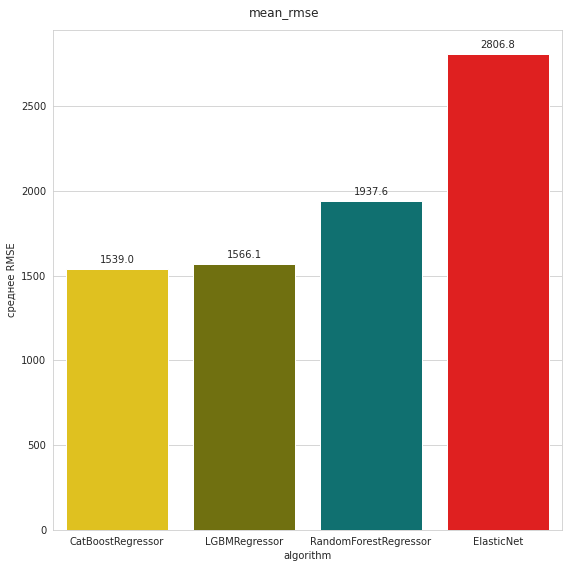

In [64]:
# применение функции show_metric
show_metric('mean_rmse', ylabel='среднее RMSE')

Мы видим, что:
- наилучшее среднее значение *RMSE* (1539.0) продемонстрировала модель *CatBoostRegressor* (но при этом разница между значениями *CatBoostRegressor* и *LGBMRegressor* является незначительной);
- среднее значение *RMSE* модели *ElasticNet* (2806.8) не соответствует требованиям заказчика.

### Время обучения

Проанализируем время обучения моделей:

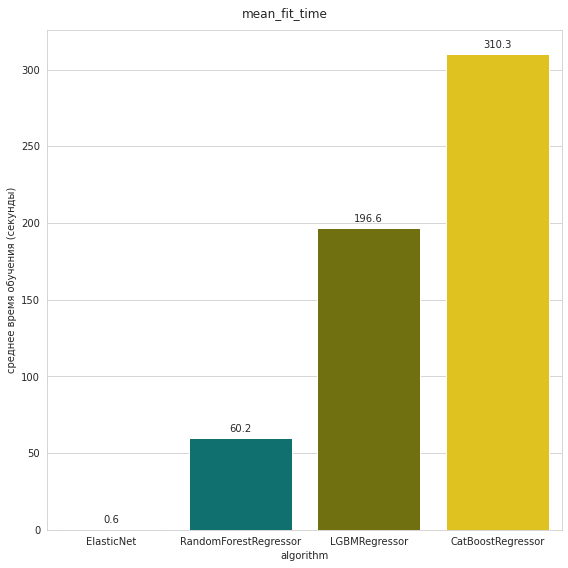

In [65]:
# применение функции show_metric
show_metric('mean_fit_time', ylabel='среднее время обучения (секунды)')

Мы видим, что:

- наилучшее среднее время обучения (0.6 секунды) продемонстрировала модель *ElasticNet*, наихудшее время (310.3 секунд) - *CatBoostRegressor*;
- только у двух моделей (*ElasticNet* и *RandomForestRegressor*) среднее время обучения находится в пределах 1 минуты.

### Время предсказания

Проанализируем время предсказания моделей:

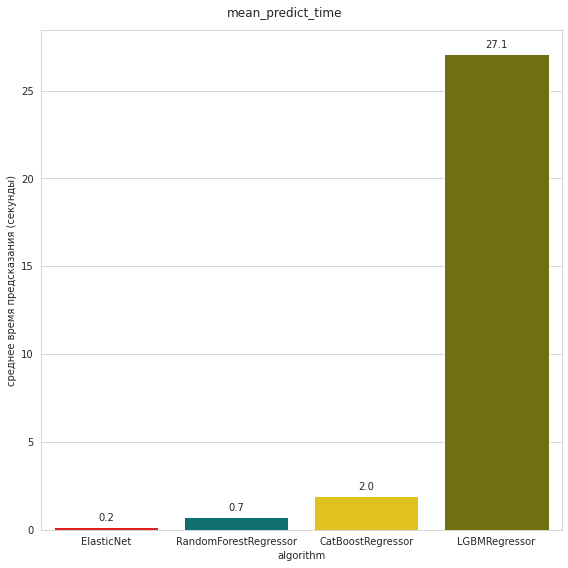

In [66]:
# применение функции show_metric
show_metric('mean_predict_time', ylabel='среднее время предсказания (секунды)')

Мы видим, что:

- наилучшее среднее время предсказания (0.2 секунды) продемонстрировала модель *ElasticNet*, наихудшее время (27.1 секунды) - *LGBMRegressor*;
- только у двух моделей (*ElasticNet* и *RandomForestRegressor*) среднее время предсказания находится в пределах 1 секунды;
- среднее время предсказания модели *LGBMRegressor* многократно превышает показатели остальных трех моделей и, на наш взгляд, не соответствует ожиданиям пользователей сервиса.

### Влияние признаков на предсказания моделей

По каждой модели также проанализируем влияние признаков на предсказания:

#### ElasticNet

In [67]:
# создание списка с названиями признаков
enet_feature_names = list(features_train_en_rf.columns)

# создание датасета с коэффициентами и корреспондирующими им названиями признаков
enet_coef = pd.DataFrame(
    enet.coef_,
    columns=['coef'],
    index=enet_feature_names)

# перенос знака коэффициента в отдельный столбец
enet_coef['coef_sign'] = enet_coef.apply(
    lambda x: '+' if x.coef > 0 else '-', axis=1)
enet_coef['coef'] = np.abs(enet_coef['coef'])

# сортировка коэффициентов по убыванию
enet_coef.sort_values(by='coef', ascending=False, inplace=True)

# вывод на экран признаков, наиболее и наименее повлиявших на предсказания модели
print('Признаки, наиболее влияющие на предсказания модели:')
print()
print('Увеличивающие предсказание:')
display(enet_coef.query('coef_sign == "+"').head(5))
print()
print('Понижающие предсказание:')
display(enet_coef.query('coef_sign == "-"').head(5))
print()
print('Признаки, наименее влияющие на предсказания модели:')
enet_coef.tail(10)

Признаки, наиболее влияющие на предсказания модели:

Увеличивающие предсказание:


,coef,coef_sign
Power,1858.820008,+
RegistrationYear,1565.645450,+
Brand_volkswagen,1093.994270,+
VehicleType_suv,1088.108603,+
Brand_audi,912.434596,+



Понижающие предсказание:


,coef,coef_sign
VehicleType_unknown,1796.267858,-
Kilometer,1467.780176,-
NotRepaired_yes,1347.374851,-
VehicleType_small,702.342910,-
NotRepaired_unknown,647.637561,-



Признаки, наименее влияющие на предсказания модели:


,coef,coef_sign
Brand_nissan,0.0,-
Brand_lancia,0.0,-
Brand_lada,0.0,-
Brand_jeep,0.0,-
VehicleType_other,0.0,-
Brand_daihatsu,0.0,-
FuelType_other,0.0,-
FuelType_hybrid,0.0,-
FuelType_electric,0.0,-
Brand_honda,0.0,-


Мы видим, что:
- наибольшее положительное влияние на предсказания модели оказали мощность, год регистрации, тип автомобиля *SUV* и марки автомобиля *Wolkswagen* и *Audi*;
- наибольшее отрицательное влияние на предсказания модели оказали километраж, информации о типе автомобиля и тип автомобиля *small*, а также нахождение автомобиля в ремонте и отсутствие информации об этом;
- в составе признаков, наименее влияющих на предсказания модели, определенные марки автомоблия, а также электрический тип топлива.

#### RandomForestRegressor

In [68]:
# применение функции show_feature_importances
show_feature_importances(rforest, features_train_en_rf)

Наиболее важные признаки:


,feature,feature_importance
0,RegistrationYear,0.620503
1,Power,0.287854
2,Kilometer,0.045508
3,VehicleType_convertible,0.012730
4,NotRepaired_yes,0.007582



Наименее важные признаки:


,feature,feature_importance
55,Brand_mitsubishi,7.001266e-07
56,Brand_lancia,1.348879e-07
57,Brand_daewoo,1.069904e-07
58,Brand_daihatsu,7.099396e-09
59,FuelType_other,0.000000e+00


Мы видим, что:
- основное влияние на предсказания модели оказали мощность, год регистрации и километраж (они определяют 95% предсказания); 
- наибольшее влияние оказывает год регистрации (он определяет 62% предсказания).

#### CatBoostRegressor

In [69]:
# применение функции show_feature_importances
show_feature_importances(cboost, features_train)

Наиболее важные признаки:


,feature,feature_importance
0,RegistrationYear,37.397971
1,Power,26.981305
2,Kilometer,9.729642
3,VehicleType,7.404058
4,Brand,6.744334



Наименее важные признаки:


,feature,feature_importance
6,NotRepaired,3.069592
7,PostalCode,1.193084
8,Gearbox,0.794640
9,RegistrationMonth,0.489556
10,FuelType,0.296153


Мы видим, что:
- основное влияние на предсказания модели оказали год регистрации, мощность и километраж, тип автомобиля и бренд (они определяют ~88% предсказания); 
- наибольшее влияние оказывают год регистрации и мощность (он определяют более 60% предсказания);
- влияние почтового индекса, месяца регистрации, типа коробки передач и типа топлива на прогноз очень ограниченно (они определяют менее 3% прогноза), т.е. их можно удалить для увеличения скорости обучения и предсказания модели.

#### LGBMRegressor

In [70]:
show_feature_importances(lgbm, features_train_lgbm)

Наиболее важные признаки:


,feature,feature_importance
0,Power,16075
1,RegistrationYear,12462
2,PostalCode,11808
3,Model,5062
4,RegistrationMonth,4000



Наименее важные признаки:


,feature,feature_importance
6,Brand,2197
7,VehicleType,1700
8,Gearbox,1520
9,NotRepaired,1226
10,FuelType,65


Мы видим, что:
- основное влияние на предсказания модели оказали мощность, год регистрации и почтовый индекс владельца анкеты; 
- влияние типа коробки передач, статуса ремонта и типа топлива на прогноз ограниченно, т.е. их можно удалить для увеличения скорости обучения и предсказания модели.

### Выводы

По итогам анализа моделей мы пришли к следующим выводам:

*Качество*

- наилучшее среднее значение *RMSE* (1539.0) продемонстрировала модель *CatBoostRegressor* (но при этом разница между значениями *CatBoostRegressor* *LGBMRegressor* является незначительной);
- среднее значение *RMSE* модели *ElasticNet* (2806.8) не соответствует требованиям заказчика.

*Время обучения*

- наилучшее среднее вреия обучения (0.6 секунды) продемонстрировала модель *ElasticNet*, наихудшее время (310.3 секунд) - *CatBoostRegressor*;
- только у двух моделей (*ElasticNet* и *RandomForestRegressor*) среднее время обучения находится в пределах 1 минуты.

*Время предсказания*

- наилучшее среднее время предсказания (0.2 секунды) продемонстрировала модель *ElasticNet*, наихудшее время (27.1 секунды) - *LGBMRegressor*;
- только у двух моделей (*ElasticNet* и *RandomForestRegressor*) среднее время предсказания находится в пределах 1 секунды;
- среднее время предсказания модели *LGBMRegressor* многократно превышает показатели остальных трех моделей и, на наш взгляд, не соответствует ожиданиям пользователей сервиса.

*Влияние признаков на предсказания моделей*

- *ElasticNet*:
  - наибольшее положительное влияние на предсказания модели оказали мощность, год регистрации, тип автомобиля *SUV* и марки автомобиля *Wolkswagen* и *Audi*;
  - наибольшее отрицательное влияние на предсказания модели оказали километраж, информации о типе автомобиля и тип автомобиля *small*, а также нахождение автомобиля в ремонте и отсутствие информации об этом;
  - в составе признаков, наименее влияющих на предсказания модели, определенные марки автомоблия, а также электрический тип топлива.
- *RandomForestRegressor*:
  - основное влияние на предсказания модели оказали мощность, год регистрации и километраж (они определяют 95% предсказания); 
  - наибольшее влияние оказывает год регистрации (он определяет 62% предсказания).
- *CatBoostRegressor*:
  - основное влияние на предсказания модели оказали год регистрации, мощность и километраж, тип автомобиля и бренд (они определяют ~88% предсказания); 
  - наибольшее влияние оказывают год регистрации и мощность (он определяют более 60% предсказания);
  - влияние почтового индекса, месяца регистрации, типа коробки передач и типа топлива на прогноз очень ограниченно (они определяют менее 3% прогноза), т.е. их можно удалить для увеличения скорости обучения и предсказания модели.
- *LGBMRegressor*:
  - основное влияние на предсказания модели оказали мощность, год регистрации и почтовый индекс владельца анкеты; 
  - влияние типа коробки передач, статуса ремонта и типа топлива на прогноз ограниченно, т.е. их можно удалить для увеличения скорости обучения и предсказания модели.

Мы видим, что:
- модели с лучшими показателями качества (*CatBoostRegressor* и *LGBMRegressor*) демонстрируют худшие показатели времени обучения и предсказания;
- ряд признаков, на которых обучались такие модели, очень ограниченно влияют на предсказания моделей.

На следующем этапе повторно обучим модели *CatBoostRegressor* и *LGBMRegressor*, используя ранее подобранные гиперпараметры и исключив из выборов признаки, влияние которых на предсказания ограниченно.

## Повторное обучение и анализ моделей *CatBoostRegressor* и *LGBMRegressor*

На данном этапе мы:
- исключим из выборок моделей *CatBoostRegressor* и *LGBMRegressor* признаки с низкой важностью для предсказаний;
- повторно обучим эти модели, используя ранее подобранные гиперпараметры;
- сравним метрики переобученных моделей с метриками моделей, обученных на первом круге.

### Подготовка нового сета выборок для *CatBoostRegressor*

Создадим новый сет выборок для модели *CatBoostRegressor*, исключив из них признаки с низкой важностью для предсказаний:

In [71]:
# создание копий features_train и features_test
features_train_cboost = features_train.copy()
features_test_cboost = features_test.copy()

In [72]:
# создание списка с названиями исключаемых признаков 
cboost_features_to_remove = ['PostalCode', 'Gearbox', 'RegistrationMonth', 'FuelType']

In [73]:
# исключение признаков
features_train_cboost.drop(columns=cboost_features_to_remove, inplace=True)
features_test_cboost.drop(columns=cboost_features_to_remove, inplace=True)

# проверка исключения признаков
for subset in features_train_cboost, features_test_cboost:
    print(subset.columns)
    print()

Index(['VehicleType', 'RegistrationYear', 'Power', 'Model', 'Kilometer',
       'Brand', 'NotRepaired'],
      dtype='object')

Index(['VehicleType', 'RegistrationYear', 'Power', 'Model', 'Kilometer',
       'Brand', 'NotRepaired'],
      dtype='object')



In [74]:
# обновление списка категориальных признаков (для передачи модели CatBoostRegressor)
cat_features_names = [col for col in features_train_cboost.columns if col not in features_numeric]

# проверка обновления списка категориальных признаков
cat_features_names

['VehicleType', 'Model', 'Brand', 'NotRepaired']

### Подготовка нового сета выборок для *LGBMRegressor*

Создадим новый сет выборок для модели *LGBMRegressor*, исключив из них признаки с низкой важностью для предсказаний:

In [75]:
# обновление списка признаков
features_train_lgbm.drop(columns=['Gearbox', 'NotRepaired', 'FuelType'], inplace=True)
features_test_lgbm.drop(columns=['Gearbox', 'NotRepaired', 'FuelType'], inplace=True)

# проверка исключения признаков
for subset in features_train_lgbm, features_test_lgbm:
    print(subset.columns)
    print()

Index(['VehicleType', 'RegistrationYear', 'Power', 'Model', 'Kilometer',
       'RegistrationMonth', 'Brand', 'PostalCode'],
      dtype='object')

Index(['VehicleType', 'RegistrationYear', 'Power', 'Model', 'Kilometer',
       'RegistrationMonth', 'Brand', 'PostalCode'],
      dtype='object')



### Повторное обучение *СatBoostRegressor*

Повторно создадим модель, используя подобранные на этапе 4 гиперпараметры:

In [76]:
# создание словаря с параметрами модели
cboost_v2_model_params = {'cat_features': cat_features_names,
                       'loss_function': 'RMSE',
                       'random_state': 12345,
                       'verbose': 100,
                       'learning_rate': 0.1,
                       'iterations': 2000}

In [77]:
# создание модели
cboost_v2 = cb.CatBoostRegressor(**cboost_v2_model_params)

Получим метрики модели при помощи инструмента *cross_validate* (используя новый сет признаков) и сохраним их в сравнительную таблицу:

In [78]:
%%time

# получение метрик модели при помощи cross_validate
cboost_v2_cv_results = cross_validate(cboost_v2, features_train_cboost, target_train, 
                            cv=3, scoring='neg_root_mean_squared_error', verbose=2, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 4288.0311729	total: 149ms	remaining: 4m 57s
100:	learn: 1723.3760745	total: 9.78s	remaining: 3m 3s
200:	learn: 1651.3298003	total: 18.9s	remaining: 2m 49s
300:	learn: 1616.1210071	total: 28.3s	remaining: 2m 39s
400:	learn: 1590.6020205	total: 37.1s	remaining: 2m 28s
500:	learn: 1569.1968271	total: 46.5s	remaining: 2m 19s
600:	learn: 1551.8338461	total: 55.9s	remaining: 2m 10s
700:	learn: 1538.5934673	total: 1m 5s	remaining: 2m
800:	learn: 1526.8966963	total: 1m 15s	remaining: 1m 52s
900:	learn: 1515.7325905	total: 1m 24s	remaining: 1m 43s
1000:	learn: 1504.9303138	total: 1m 34s	remaining: 1m 34s
1100:	learn: 1495.3936127	total: 1m 43s	remaining: 1m 24s
1200:	learn: 1485.8859725	total: 1m 53s	remaining: 1m 15s
1300:	learn: 1477.8257451	total: 2m 2s	remaining: 1m 6s
1400:	learn: 1471.2195656	total: 2m 12s	remaining: 56.7s
1500:	learn: 1464.4800169	total: 2m 22s	remaining: 47.3s
1600:	learn: 1458.1225988	total: 2m 31s	remaining: 37.8s
1700:	learn: 1451.9610544	total: 2m 41s	rema

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.2min remaining:    0.0s


0:	learn: 4280.3014010	total: 122ms	remaining: 4m 3s
100:	learn: 1724.9977002	total: 9.44s	remaining: 2m 57s
200:	learn: 1655.5550053	total: 18.4s	remaining: 2m 44s
300:	learn: 1616.6992760	total: 27.3s	remaining: 2m 34s
400:	learn: 1586.4506481	total: 36.6s	remaining: 2m 26s
500:	learn: 1566.4738788	total: 45.7s	remaining: 2m 16s
600:	learn: 1550.1193672	total: 55.4s	remaining: 2m 8s
700:	learn: 1535.1842979	total: 1m 5s	remaining: 2m
800:	learn: 1521.3649163	total: 1m 14s	remaining: 1m 52s
900:	learn: 1509.4935401	total: 1m 24s	remaining: 1m 42s
1000:	learn: 1498.5827855	total: 1m 33s	remaining: 1m 33s
1100:	learn: 1489.4299350	total: 1m 43s	remaining: 1m 24s
1200:	learn: 1480.6928621	total: 1m 52s	remaining: 1m 14s
1300:	learn: 1472.9948836	total: 2m 2s	remaining: 1m 5s
1400:	learn: 1465.1343262	total: 2m 12s	remaining: 56.5s
1500:	learn: 1458.2441906	total: 2m 21s	remaining: 47.1s
1600:	learn: 1451.4966576	total: 2m 31s	remaining: 37.8s
1700:	learn: 1445.4922492	total: 2m 41s	remai

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  9.8min finished


In [79]:
# сохранение метрик модели сравнительную таблицу
cboost_v2_metrics = ['CatBoostRegressor_v2', {'learning_rate': 0.1, 'iterations': 2000}]
    
for metric in ('test_score', 'fit_time', 'score_time'):
    metric_sum = np.abs(np.sum(cboost_v2_cv_results[metric]))
    metric_count = len(cboost_v2_cv_results[metric])
    metric_mean = metric_sum / metric_count
    cboost_v2_metrics.append(metric_mean)
    
df_model_comparison.loc[len(df_model_comparison)] = cboost_v2_metrics

Также обучим модель на всей обучающей выборке:

In [80]:
# обучение модели
cboost_v2.fit(features_train_cboost, target_train)

0:	learn: 4283.0198526	total: 176ms	remaining: 5m 51s
100:	learn: 1715.9538410	total: 14.8s	remaining: 4m 37s
200:	learn: 1650.6772482	total: 28.9s	remaining: 4m 18s
300:	learn: 1613.7045087	total: 43.5s	remaining: 4m 5s
400:	learn: 1589.3837326	total: 57.3s	remaining: 3m 48s
500:	learn: 1569.1273520	total: 1m 12s	remaining: 3m 36s
600:	learn: 1554.2874669	total: 1m 27s	remaining: 3m 24s
700:	learn: 1541.7890513	total: 1m 41s	remaining: 3m 8s
800:	learn: 1529.9879791	total: 1m 55s	remaining: 2m 53s
900:	learn: 1519.8211754	total: 2m 10s	remaining: 2m 38s
1000:	learn: 1510.9632158	total: 2m 27s	remaining: 2m 26s
1100:	learn: 1502.6622543	total: 2m 43s	remaining: 2m 13s
1200:	learn: 1495.2021760	total: 2m 58s	remaining: 1m 58s
1300:	learn: 1487.7503144	total: 3m 13s	remaining: 1m 44s
1400:	learn: 1480.5573165	total: 3m 28s	remaining: 1m 29s
1500:	learn: 1474.3234775	total: 3m 43s	remaining: 1m 14s
1600:	learn: 1468.8126168	total: 3m 57s	remaining: 59.3s
1700:	learn: 1463.0464455	total: 4

### Повторное обучение *LGBMRegressor*

Повторно создадим модель, используя подобранные на этапе 4 гиперпараметры:

In [81]:
# создание словаря с параметрами модели
lgbm_v2_model_params = {'random_state': 12345,
                       'learning_rate': 0.1,
                       'num_iterations': 2000}

In [82]:
# создание модели
lgbm_v2 = lgb.LGBMRegressor(**lgbm_v2_model_params)

Получим метрики модели при помощи инструмента *cross_validate* (используя новый сет признаков) и сохраним их в сравнительную таблицу:

In [83]:
%%time

lgbm_v2_cv_results = cross_validate(lgbm_v2, features_train_lgbm, target_train, 
                            cv=3, scoring='neg_root_mean_squared_error', verbose=2, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=29.1min


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 29.1min remaining:    0.0s


[CV] END .................................................... total time= 6.7min
[CV] END .................................................... total time= 4.7min
CPU times: user 39min 26s, sys: 16 s, total: 39min 42s
Wall time: 40min 29s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 40.5min finished


In [84]:
# сохранение метрик модели сравнительную таблицу
lgbm_v2_metrics = ['LGBMRegressor_v2', {'learning_rate': 0.1, 'num_iterations': 2000}]
    
for metric in ('test_score', 'fit_time', 'score_time'):
    metric_sum = np.abs(np.sum(lgbm_v2_cv_results[metric]))
    metric_count = len(lgbm_v2_cv_results[metric])
    metric_mean = metric_sum / metric_count
    lgbm_v2_metrics.append(metric_mean)
    
df_model_comparison.loc[len(df_model_comparison)] = lgbm_v2_metrics

Также обучим модель на всей обучающей выборке:

In [85]:
# обучение модели
lgbm_v2.fit(features_train_lgbm, target_train)

LGBMRegressor(num_iterations=2000, random_state=12345)

### Изучение метрик переобученных моделей

Изучим метрики переобученных моделей и сравним их с метриками моделей, обученных на первом круге:

In [86]:
# обновление словаря-палитры цветов моделей 
models_palette['CatBoostRegressor_v2'] = 'orange'
models_palette['LGBMRegressor_v2'] = 'magenta'

#### Качество

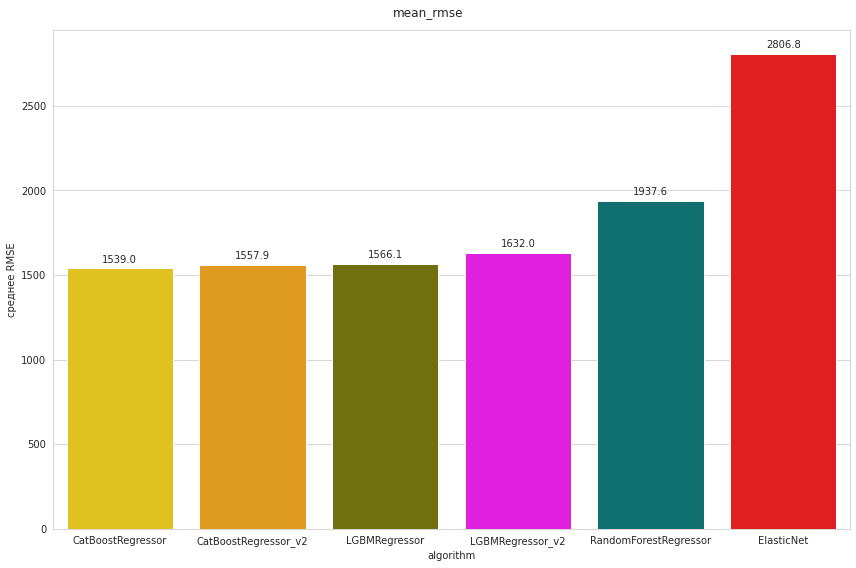

In [95]:
# применение функции show_metric
show_metric('mean_rmse', ylabel='среднее RMSE', width=12)

Мы видим, что в результате удаления признаков средние *RMSE* обеих моделей ухудшились (в случае с *CatBoostRegressor* такое ухуждение незначительно). Вместе с тем, модели продолжают занимать первые два места по данной метрике.

#### Время обучения

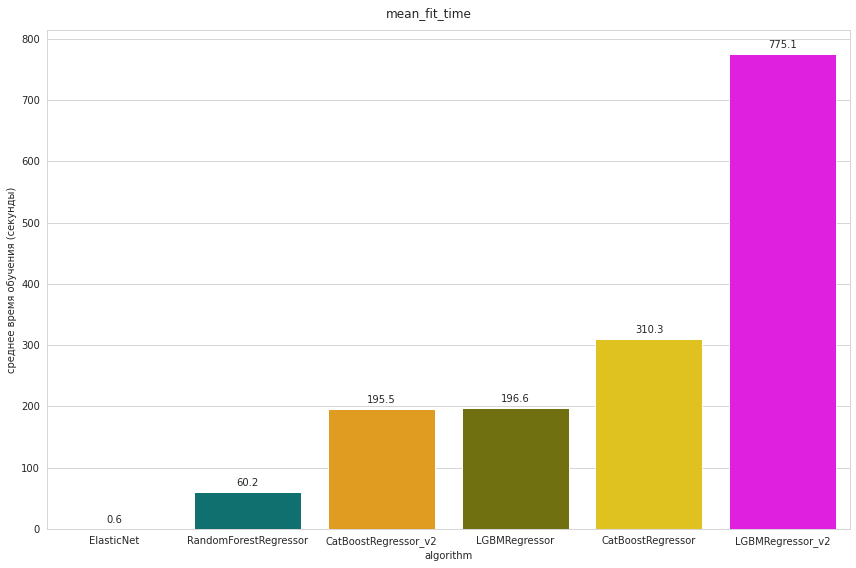

In [94]:
# применение функции show_metric
show_metric('mean_fit_time', ylabel='среднее время обучения (секунды)', width=12)

Мы видим, что в результате удаления признаков:
- среднее время обучения *CatBoostRegressor* сократилось на ~37% (до 195.5 секунд), но при этом модель занимает только третье место по данной метрике (после *ElasticNet* и *RandomForestRegressor*);
- среднее время обучения *LGBMRegressor* увеличилось более чем на 100% (до 775.1 секунд); к сожалению, мы не можем объяснить причины данного изменения.

#### Время предсказания

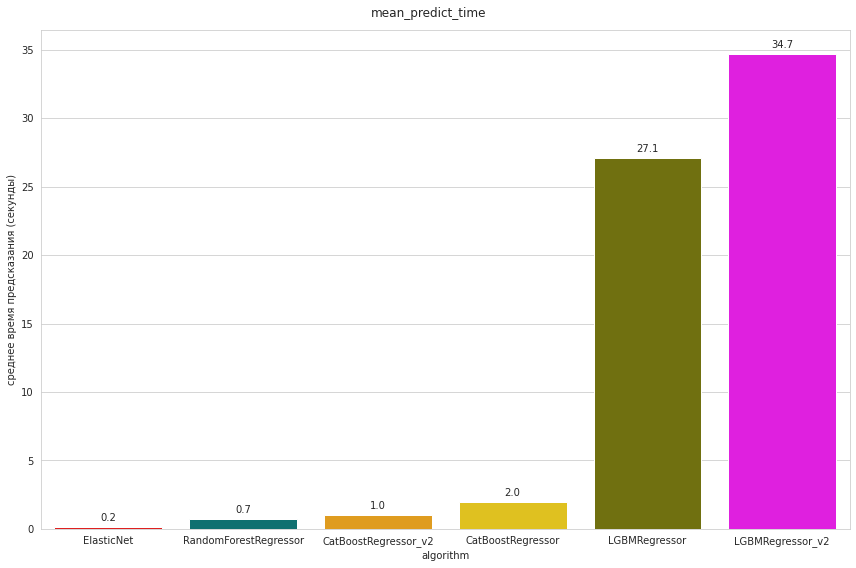

In [96]:
# применение функции show_metric
show_metric('mean_predict_time', ylabel='среднее время предсказания (секунды)', width=12)

Мы видим, что в результате удаления признаков:

- среднее время предсказания *CatBoostRegressor* сократилось на 50% (до 1 секунды);
- среднее время предсказания *LGBMRegressor* также ухудшилось, модель продолжает занимать последнее место по данному показателю и демонстрировать время предсказания, которое, по нашему мнению, не соответствует ожиданиям пользователей сервиса.

### Выводы

На данном этапе мы:
- исключили из выборок моделей *CatBoostRegressor* и *LGBMRegressor* признаки с низкой важностью для предсказаний;
- повторно обучили эти модели, используя ранее подобранные гиперпараметры.

В результате удаления признаков:
- *качество*: средние *RMSE* обеих моделей ухудшились (в случае с *CatBoostRegressor* такое ухуждение незначительно). Вместе с тем, модели продолжают занимать первые два места по данной метрике.
- *время обучения*:
  - среднее время обучения *CatBoostRegressor* сократилось на ~37% (до 195.5 секунд), но при этом модель занимает только третье место по данной метрике (после *ElasticNet* и *RandomForestRegressor*);
  - среднее время обучения *LGBMRegressor* увеличилось более чем на 100% (до 775.1 секунд); к сожалению, мы не можем объяснить причины данного изменения.
- *время предсказания*:
  - среднее время предсказания *CatBoostRegressor* сократилось на 50% (до 1 секунды);
  - среднее время предсказания *LGBMRegressor* также ухудшилось, модель продолжает занимать последнее место по данному показателю и демонстрировать время предсказания, которое, по нашему мнению, не соответствует ожиданиям пользователей сервиса.
  
На следующем этапе выберем и протестируем лучшую модель.

## Выбор и тестирование лучшей модели

Исходя из критериев заказчика мы выбрали *CatBoostRegressor* (вторую версию) в качестве лучшей модели: данная модель показала наилучшее (среди моделей на основе других алгоритмов) среднее значение *RMSE* (1557.9), и при этом сопоставимое с другими моделями время предсказания (1 секунда).

In [97]:
# сохранение лучшей модели в переменную best_model
best_model = cboost_v2

Протестируем лучшую модель на тестовой выборке:

In [98]:
# получение предсказаний лучшей модели на тестовой выборке
best_model_preds_test = best_model.predict(features_test_cboost)

# расчет и вывод на экран RMSE лучшей модели на тестовой выборке
best_model_rmse_test = mean_squared_error(target_test, best_model_preds_test, 
                                          squared=False)
print('RMSE лучшей модели на тестовой выборке:', best_model_rmse_test)

RMSE лучшей модели на тестовой выборке: 1539.3402622093129


Мы видим, что лучшая модель продемонстрировала на тестовой выборке значение *RMSE* 1539, что незначительно лучше ее среднего значения на обучающей выборке.

Сравним полученное значение с целевым показателем метрики:

In [99]:
# сохранение цели по метрике качества в отдельную переменную
rmse_target = 2500

# расчет и вывод на экран количества процентов, на которые RMSE лучшей модели ниже
# целевого RMSE
best_model_advantage_target = np.abs(best_model_rmse_test - rmse_target) / rmse_target

print('На тестовой выборке RMSE лучшей модели на', '{:.2%}'.format(best_model_advantage_target), 
      'ниже целевого RMSE.')

На тестовой выборке RMSE лучшей модели на 38.43% ниже целевого RMSE.


Также сравним полученное значение с показателем константной модели:

In [100]:
# создание константной модели
dummy = DummyRegressor(strategy='mean')

# обучение константной модели 
dummy.fit(features_train, target_train)

# получение предсказаний константной модели на тестовой выборке
dummy_preds_test = dummy.predict(features_test)

# расчет и вывод на экран RMSE константной модели на тестовой выборке
dummy_rmse_test = mean_squared_error(target_test, dummy_preds_test, 
                                          squared=False)
print('RMSE константной модели на тестовой выборке:', dummy_rmse_test)

RMSE константной модели на тестовой выборке: 4582.897738781543


In [101]:
# расчет и вывод на экран количества процентов, на которые RMSE лучшей модели ниже
# RMSE константной модели
best_model_advantage_dummy = np.abs(best_model_rmse_test - dummy_rmse_test) / dummy_rmse_test

print('На тестовой выборке RMSE лучшей модели на', '{:.2%}'.format(best_model_advantage_dummy), 
      'ниже RMSE константной модели.')

На тестовой выборке RMSE лучшей модели на 66.41% ниже RMSE константной модели.


### Выводы

На данном этапе мы:
- исходя из критериев заказчика мы выбрали *CatBoostRegressor* (вторую версию) в качестве лучшей модели: данная модель показала наилучшее (среди моделей на основе других алгоритмов) среднее значение *RMSE* (1557.9), и при этом сопоставимое с другими моделями время предсказания (1 секунда);
- рассчитали *RMSE* лучшей модели на тестовой выборке и сравнили его с таргетом по качеству и показателем константной модели.

Лучшая модель продемонстрировала на тестовой выборке значение *RMSE* 1539, что:
- незначительно лучше ее среднего значения на обучающей выборке;
- на ~38% лучше таргета по качеству (2500); и
- на ~66% лучше *RMSE* констрантной модели.

## Общие выводы

В ходе проекта мы построили модель для предсказания рыночной стоимости поддержанных автомобилей для приложения сервиса по продаже автомобилей с пробегом «Не бит, не крашен».

Работа над проектом включала семь этапов:

1. загрузка и изучение данных;
2. подготовка данных; 
3. подготовка выборок к обучению моделей;
4. обучение моделей;
5. анализ моделей;
6. повторное обучение моделей; и
7. выбор и тестирование лучшей модели.

**1. Загрузка и изучение данных**

На данном этапе мы загрузили и изучили данные. По результатам изучения данных мы пришли к следующим выводам:

*Общие выводы*

- в датасете 354 369 объектов, один объект содержит информацию об одной анкете о продаже автомобиля;
- по каждому объекто доступно 16 признаков:
    - 5 количественных (*Price*, *RegistrationYear*, *Power*, *Kilometer*, *NumberOfPictures*);
    - 8 категориальных (*VehicleType*, *Gearbox*, *Model*, *RegistrationMonth*, *FuelType*, *Brand*, *NotRepaired*, *PostalCode*);
    - 3 календарных (*DateCrawled*, *DateCreated*, *LastSeen*).
- в значениях 5 категориальных признаков есть пропуски, их процент составлет ~6-20 процентов.

*Количественные признаки*

- все количественные признаки имеют тип *int64*; в зависимости от диапазона их значений в целях оптимизации данных возможно изменить их тип на *int64*, *int16* или *int8*;
- признак *NumberOfPictures* содержит только нулевые значения (т.е. данный признак неинформативен для целей построения модели);
- признаки *Price* *RegistrationYear* и *Power* содержат аномальные минимальное и максимальное значения (по итогам их анализа мы подобрали пороги нормальных значений);
- признаки *Price* и *Power* содержат нулевые значения (~3-11 процентов), которые могут быть неявными пропусками.

*Категориальныпе признаки*

- признаки *Model* и *PostalCode* содержат 250 и 8 143 уникальных значений, поэтому использование данных признаков для построения моделей на основе алгоритмов, требующих кодирования категориальных признаков, может существенно увеличить время обучения таких моделей;
- категориальные признаки не содержат аномальных значени;
- признаки *FuelType*, *Brand* и *Model* содержат неявные дубликаты.

*Календарные признаки*

- календарные признаки имеют тип *object*, для работы с данными признаками необходимо изменить их тип на *datetime*;
- в датасете представлены данные об анкетах, размещенных с марта 2014 по апрель 2016 года;
- анкеты были скачаны с сайта с марта по апрель 2016 года;
- аномалии не выявлены.

**2. Подготовка данных**

В ходе подготовки данных мы:

- устранили пропуски в признаках *NotRepaired*, *VehicleType*, *FuelType*, *Gearbox* и *Model* путем их заполнения значением-индикатором пропуска *unknown*; 
- устранили аномальные значения в признаках *Price*, *RegistrationYear* и *Power* путем удаления содержащих их объектов;
- устранили неявные дубликаты в признаках *FuelType*, *Brand* и Model*;
- удадлили объекты, которые мы классифицировали как явные дубликаты; и
- оптимизировали тип данных признаков с числовыми значениями, уменьшив размер датасетас 35,8 до 26,5 Мб.

В результате подготовки данных количество объектов в датасете сократилось на ~17%.

**3. Подготовка выборок к обучению моделей**

На данном этапе мы:

- удалили неинформативные признаки *NumberOfPictures*, *DateCrawled*, *DateCreated* и *LastSeen*;
- сохранили признаки и целевой признак в отдельные переменные;
- разделили данные на обучающую и тестовую выборки;
- подготовили отдельный сет выборок для *ElasticNet* и *RandomForestRegressor*:
   - масштабировли количественные признаки методом стандартизации данных;
   - кодировали категориальные признаки методом *One-Hot Encoding* (предварительно удалив признаки *Model* и *PostalCode* для снижения времени обучения моделей);
- подготовили отдельный сет выборок для *LGBMRegressor*: измененили типа категориальных признаков на *category*.

**4. Обучение моделей**

На данном этапе мы:

- для удобства обучения создали функции *random_search* и *add_to_comparison*;
- обучили модели 4 модели (*ElasticNet*, *RandomForestRegressor*, *CatBoostRegressor* и *LGBMRegressor*); и
- в рамках обучения при помощи *RandomizedSearchCV* оптимиизировали значения гиперпараметров, чтобы получить лучшее среднее значение *RMSE*.

**5. Анализ моделей**

По итогам анализа моделей мы пришли к следующим выводам:

*Качество*

- наилучшее среднее значение *RMSE* (1539.0) продемонстрировала модель *CatBoostRegressor* (но при этом разница между значениями *CatBoostRegressor* *LGBMRegressor* является незначительной);
- среднее значение *RMSE* модели *ElasticNet* (2806.8) не соответствует требованиям заказчика.

*Время обучения*

- наилучшее среднее вреия обучения (0.6 секунды) продемонстрировала модель *ElasticNet*, наихудшее время (310.3 секунд) - *CatBoostRegressor*;
- только у двух моделей (*ElasticNet* и *RandomForestRegressor*) среднее время обучения находится в пределах 1 минуты.

*Время предсказания*

- наилучшее среднее время предсказания (0.2 секунды) продемонстрировала модель *ElasticNet*, наихудшее время (27.1 секунды) - *LGBMRegressor*;
- только у двух моделей (*ElasticNet* и *RandomForestRegressor*) среднее время предсказания находится в пределах 1 секунды;
- среднее время предсказания модели *LGBMRegressor* многократно превышает показатели остальных трех моделей и, на наш взгляд, не соответствует ожиданиям пользователей сервиса.

*Влияние признаков на предсказания моделей*

- *ElasticNet*:
  - наибольшее положительное влияние на предсказания модели оказали мощность, год регистрации, тип автомобиля *SUV* и марки автомобиля *Wolkswagen* и *Audi*;
  - наибольшее отрицательное влияние на предсказания модели оказали километраж, информации о типе автомобиля и тип автомобиля *small*, а также нахождение автомобиля в ремонте и отсутствие информации об этом;
  - в составе признаков, наименее влияющих на предсказания модели, определенные марки автомоблия, а также электрический тип топлива.
- *RandomForestRegressor*:
  - основное влияние на предсказания модели оказали мощность, год регистрации и километраж (они определяют 95% предсказания); 
  - наибольшее влияние оказывает год регистрации (он определяет 62% предсказания).
- *CatBoostRegressor*:
  - основное влияние на предсказания модели оказали год регистрации, мощность и километраж, тип автомобиля и бренд (они определяют ~88% предсказания); 
  - наибольшее влияние оказывают год регистрации и мощность (он определяют более 60% предсказания);
  - влияние почтового индекса, месяца регистрации, типа коробки передач и типа топлива на прогноз очень ограниченно (они определяют менее 3% прогноза), т.е. их можно удалить для увеличения скорости обучения и предсказания модели.
- *LGBMRegressor*:
  - основное влияние на предсказания модели оказали мощность, год регистрации и почтовый индекс владельца анкеты; 
  - влияние типа коробки передач, статуса ремонта и типа топлива на прогноз ограниченно, т.е. их можно удалить для увеличения скорости обучения и предсказания модели.

Мы видим, что:
- модели с лучшими показателями качества (*CatBoostRegressor* и *LGBMRegressor*) демонстрируют худшие показатели времени обучения и предсказания;
- ряд признаков, на которых обучались такие модели, очень ограниченно влияют на предсказания моделей.

**6. Повтороное обучение моделей** 

На данном этапе мы:
- исключили из выборок моделей *CatBoostRegressor* и *LGBMRegressor* признаки с низкой важностью для предсказаний;
- повторно обучили эти модели, используя ранее подобранные гиперпараметры.

В результате удаления признаков:
- *качество*: средние *RMSE* обеих моделей ухудшились (в случае с *CatBoostRegressor* такое ухуждение незначительно). Вместе с тем, модели продолжают занимать первые два места по данной метрике.
- *время обучения*:
  - среднее время обучения *CatBoostRegressor* сократилось на ~37% (до 195.5 секунд), но при этом модель занимает только третье место по данной метрике (после *ElasticNet* и *RandomForestRegressor*);
  - среднее время обучения *LGBMRegressor* увеличилось более чем на 100% (до 775.1 секунд); к сожалению, мы не можем объяснить причины данного изменения.
- *время предсказания*:
  - среднее время предсказания *CatBoostRegressor* сократилось на 50% (до 1 секунды);
  - среднее время предсказания *LGBMRegressor* также ухудшилось, модель продолжает занимать последнее место по данному показателю и демонстрировать время предсказания, которое, по нашему мнению, не соответствует ожиданиям пользователей сервиса.

**7. Выбор и тестирование лучшей модели**

На данном этапе мы:
- исходя из критериев заказчика мы выбрали *CatBoostRegressor* (вторую версию) в качестве лучшей модели: данная модель показала наилучшее (среди моделей на основе других алгоритмов) среднее значение *RMSE* (1557.9), и при этом сопоставимое с другими моделями время предсказания (1 секунда);
- рассчитали *RMSE* лучшей модели на тестовой выборке и сравнили его с таргетом по качеству и показателем константной модели.

Лучшая модель продемонстрировала на тестовой выборке значение *RMSE* 1539, что:
- незначительно лучше ее среднего значения на обучающей выборке;
- на ~38% лучше таргета по качеству (2500); и
- на ~66% лучше *RMSE* констрантной модели.